# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *



Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    for i in range(num_examples):
        print "Training Example:\n", i
        print "\nLabel of Message:\n", newsgroups_train.target_names[train_labels[i]]
        print "\nText of Message:\n", train_data[i]
        print "\n- - - - -\n"
### STUDENT END ###
P1(5)

Training Example:
0

Label of Message:
comp.graphics

Text of Message:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

- - - - -

Training Example:
1

Label of Message:
talk.religion.misc

Text of Message:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [4]:
def P2():
### STUDENT START ###
    # a
    print "a."
    cv = CountVectorizer()
    cv_matrix = cv.fit_transform(train_data)
    print "Size of the vocabulary:", len(cv.get_feature_names())
    print "Average number of non-zero features per example:", float(cv_matrix.nnz) / len(train_data)
    print "Fraction of non-zero entries:", float(cv_matrix.nnz) / (cv_matrix.shape[0] * cv_matrix.shape[1])
    
    # b
    print "\nb."
    print "0th and last feature strings:", cv.get_feature_names()[0], "and", cv.get_feature_names()[-1]
    
    # c
    print "\nc."
    cv.fit(["atheism", "graphics", "space", "religion"])
    cv_new_matrix = cv.transform(train_data)
    print "Shape of training vector with vocabulary of 4 words:", cv_new_matrix.shape
    print "Average number of non-zero features per example:", float(cv_new_matrix.nnz) / len(train_data)
    
    # d
    print "\nd."
    cv = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    cv.fit(train_data)
    print "Size of vocabulary bigram/trigram using analyzer='char':", len(cv.get_feature_names())
    
    # e
    print "\ne."
    cv = CountVectorizer(min_df=10)
    cv.fit(train_data)
    print "Size of vocabulary with min_df = 10:", len(cv.get_feature_names())
    
    # f
    print "\nf."
    # Using Python set object to find words in dev missing from train
    cv = CountVectorizer()
    
    cv.fit(train_data)
    train_vocab = set(cv.get_feature_names())                # Creating train vocabulary set
    
    cv.fit(dev_data)
    dev_vocab = set(cv.get_feature_names())                 # Creating test vocabulary set
    # Perform set diff
    print "Fraction of words in dev set missing from vocabulary:", float(len(dev_vocab - train_vocab)) / len(dev_vocab)

### STUDENT END ###
P2()

a.
Size of the vocabulary: 26879
Average number of non-zero features per example: 96.7059980334
Fraction of non-zero entries: 0.00359782722696

b.
0th and last feature strings: 00 and zyxel

c.
Shape of training vector with vocabulary of 4 words: (2034, 4)
Average number of non-zero features per example: 0.268436578171

d.
Size of vocabulary bigram/trigram using analyzer='char': 35478

e.
Size of vocabulary with min_df = 10: 3064

f.
Fraction of words in dev set missing from vocabulary: 0.247876400345


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [6]:
def P3():
### STUDENT START ###
    # Preparing data
    cv = CountVectorizer()
    cv.fit(train_data)

    train_data_matrix = cv.transform(train_data)
    dev_data_matrix = cv.transform(dev_data)

    # K Nearest Neighbors
    # Finding optimal k
    num = range(1, len(dev_data) + 1)                                         
    num_neighbors = {'n_neighbors': num}                                      
    knn_clf = KNeighborsClassifier()
    clf = GridSearchCV(knn_clf, num_neighbors)                  
    clf.fit(train_data_matrix, train_labels)
    print 'Optimal k for K Nearest Neighbors:', clf.best_params_

    # Calculating f1 score for optimal k
    knn_clf = KNeighborsClassifier(n_neighbors = clf.best_params_['n_neighbors'])
    knn_clf.fit(train_data_matrix, train_labels)
    knn_clf_preds = knn_clf.predict(dev_data_matrix)
    print 'KNN f1 score for k = {0} is {1}'.format(clf.best_params_['n_neighbors'], metrics.f1_score(y_true = dev_labels, y_pred = knn_clf_preds, average="macro"))

    # Multinomial NB
    # Finding Optimal alpha
    alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    mnb_clf = MultinomialNB()
    clf = GridSearchCV(mnb_clf, alphas)
    clf.fit(train_data_matrix, train_labels)
    print '\nOptimal alpha for MultinimialNB =', clf.best_params_

    # Calculating F1 score for optimal alpha
    mnb_clf = MultinomialNB(alpha = 0.01)
    mnb_clf.fit(train_data_matrix, train_labels)
    mnb_clf_preds = mnb_clf.predict(dev_data_matrix)
    print 'MultinomialNB f1 score for alpha = {0} is {1}'.format(clf.best_params_['alpha'], metrics.f1_score(y_true = dev_labels, y_pred = mnb_clf_preds, average="macro"))

    # Logistic Regression
    listofCs = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10]
    Cs = {'C': listofCs}

    # Calculating optimal C for Logistic Regression
    logit_clf = LogisticRegression(penalty = 'l2')
    clf = GridSearchCV(logit_clf, Cs)
    clf.fit(train_data_matrix, train_labels)
    print '\nOptimal C for Logistic Regression =', clf.best_params_

    # Calculating F1 score for optimal C
    logit_clf = LogisticRegression(penalty = 'l2', C = clf.best_params_['C'])
    logit_clf.fit(train_data_matrix, train_labels)
    logit_clf_preds = logit_clf.predict(dev_data_matrix)
    print 'Logistic Regression f1 Score for C = {0} is {1}'.format(clf.best_params_['C'], metrics.f1_score(y_true = dev_labels, y_pred = logit_clf_preds, average="macro"))

    # Printing sum of squared weights for each class
    print " "
    for c in listofCs:
        logit_clf = LogisticRegression(penalty = 'l2', C = c)
        logit_clf.fit(train_data_matrix, train_labels)
        logit_clf_preds = logit_clf.predict(dev_data_matrix)
     
        print "C setting:", c, ";\tSum of Squared weights:\t", np.sum(logit_clf.coef_**2, axis=1)
    
### STUDENT END ###
P3()

Optimal k for K Nearest Neighbors: {'n_neighbors': 151}
KNN f1 score for k = 151 is 0.402814934441

Optimal alpha for MultinimialNB = {'alpha': 0.01}
MultinomialNB f1 score for alpha = 0.01 is 0.755289419801

Optimal C for Logistic Regression = {'C': 0.1}
Logistic Regression f1 Score for C = 0.1 is 0.679433709916
 
C setting: 0.0001 ;	Sum of Squared weights:	[ 0.00770175  0.0119412   0.00943508  0.00910284]
C setting: 0.001 ;	Sum of Squared weights:	[ 0.16509345  0.20095275  0.18067094  0.18724278]
C setting: 0.01 ;	Sum of Squared weights:	[ 2.54147242  2.93970937  2.86246867  2.25002667]
C setting: 0.1 ;	Sum of Squared weights:	[ 27.13034695  24.65563867  27.4588348   23.02516838]
C setting: 1 ;	Sum of Squared weights:	[ 166.90926443  130.88550268  157.96129835  145.72854664]
C setting: 2 ;	Sum of Squared weights:	[ 257.47657151  197.87278484  239.81964624  226.57478908]
C setting: 5 ;	Sum of Squared weights:	[ 423.00959165  322.8624149   389.23594323  377.90657765]
C setting: 10 ;	Su

** ANSWER: **  
** a. ** K nearest neighbors uses values of features to calculate distances between observations. In this case the words in the documents are used as features. We have seen in # 2.f above, almost 25% of the words in the dev data set are not there in the vocabulary. This mismatch in features results in poorer performance by K nearest neighbors algorithm

** b. ** In this case, Logistic regression does not perform as well as Naive Bayes because the number of observations is low. If training examples were larger then Logistic regression would have been better. In this case the observations are lesser than the number of features

** c. ** C is the inverse of regularization strength so smaller values of C results in stronger regularization and hence smaller weights. So as C goes smaller the sum of the weights becomes smaller.



(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [7]:
def P4(cv, title):
### STUDENT START ###
    print title
    cv.fit(train_data)
    train_data_matrix = cv.transform(train_data)
    dev_data_matrix = cv.transform(dev_data)
    num_of_features = 5
    feature_names = np.array(cv.get_feature_names())

    logit_clf = LogisticRegression(penalty = 'l2', C = 0.1)
    logit_clf.fit(train_data_matrix, train_labels)

    sortedIndices = np.argsort(np.absolute(logit_clf.coef_), axis = 1)
    
    print "> Top 5 features per class"
    for i in range(logit_clf.coef_.shape[0]):
        print newsgroups_train.target_names[i]
        for j in sortedIndices[i, -num_of_features:logit_clf.coef_.shape[1]]:
            print "\t", feature_names[j]
    
    table = newsgroups_train.target_names
    table = np.hstack(('ROW/COL', table))
    
    print "> Table: 20 rows X 4 columns"
    for i in range(logit_clf.coef_.shape[0]):
        for j in sortedIndices[i, -num_of_features:logit_clf.coef_.shape[1]]:
            rounded_weights = np.round(logit_clf.coef_[:, j], 5)
            row = np.hstack((cv.get_feature_names()[j], rounded_weights))
            table = np.vstack((table, row))
    np.set_printoptions(linewidth=100, formatter={'all':lambda x: '{0}'.format(str(x).rjust(18))})
    print table
    print " "

# With default CountVectorizer()
cv = CountVectorizer()
P4(cv, ">> With default CountVectorizer")

# With bigram features
cv = CountVectorizer(ngram_range=(2, 2))
P4(cv, ">> With bigram features")
### STUDENT END ###

>> With default CountVectorizer
> Top 5 features per class
alt.atheism
	atheists
	bobby
	religion
	atheism
	space
comp.graphics
	computer
	file
	image
	space
	graphics
sci.space
	god
	nasa
	orbit
	graphics
	space
talk.religion.misc
	order
	blood
	christians
	christian
	space
> Table: 20 rows X 4 columns
[[           ROW/COL        alt.atheism      comp.graphics          sci.space talk.religion.misc]
 [          atheists            0.46151           -0.07941           -0.15836           -0.29527]
 [             bobby            0.47812           -0.12039           -0.16785           -0.22783]
 [          religion            0.49397           -0.29877           -0.39323            0.00391]
 [           atheism            0.49552           -0.20732           -0.19992           -0.26777]
 [             space           -0.65519           -0.71394            1.25874           -0.59024]
 [          computer           -0.03974            0.55898           -0.32903           -0.22869]
 [       

** ANSWER: **  
There are several surprising Bigram features. Bigrams consisting of stop words are appearing in the top of the list.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [8]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    max_wrd_length = 6
    s = s.lower()
    s = re.sub(r'\d{3,}', " numbers ", s)
    s = re.sub(r'\W', " ", s)
    s = re.sub(r'_', " ", s)
    
    wrds = s.split()
    new_s = ""
    for wrd in wrds:
        if len(wrd) > max_wrd_length:
            wrd = wrd[:max_wrd_length]
        new_s = new_s + " " + wrd
    return new_s
### STUDENT END ###

def P5(title, t_data, t_labels, d_data, d_labels, pre_processor, stop_words):
### STUDENT START ###
    print "\n", title
    cv = CountVectorizer(preprocessor=pre_processor, stop_words=stop_words)
    cv.fit(t_data)

    t_data_matrix = cv.transform(t_data)
    d_data_matrix = cv.transform(d_data)

    logit_clf = LogisticRegression()
    logit_clf.fit(t_data_matrix, t_labels)
    
    dict_size = len(cv.get_feature_names())
    print "\tDictionary size:", dict_size
    
    # Calculating f1 score
    logit_clf_preds = logit_clf.predict(d_data_matrix)
    f1 = metrics.f1_score(y_true = d_labels, y_pred = logit_clf_preds)
    print '\tf1 Score', f1

    return (dict_size, f1)
    
### STUDENT END ###
title = ">> Without preprocessing"
stop_words = None
no_preprocess = P5(title, train_data, train_labels, dev_data, dev_labels, empty_preprocessor, stop_words)

title = ">> With preprocessing and without stop words"
stop_words = None
preprocess_no_stopwords = P5(title, train_data, train_labels, dev_data, dev_labels, better_preprocessor, stop_words)
print "\tReduction in dictionary size (from without preprocessing):", no_preprocess[0] - preprocess_no_stopwords[0]
print "\tImprovement in f1-score", preprocess_no_stopwords[1] - no_preprocess[1]

title = ">> With preprocessing and stop words"
stop_words = 'english'
preprocess_stopwords = P5(title, train_data, train_labels, dev_data, dev_labels, better_preprocessor, stop_words)
print "\tReduction in dictionary size (from without preprocessing):", no_preprocess[0] - preprocess_stopwords[0]
print "\tImprovement in f1-score", preprocess_stopwords[1] - no_preprocess[1]


>> Without preprocessing
	Dictionary size: 33291
	f1 Score 0.702334008756

>> With preprocessing and without stop words
	Dictionary size: 18140
	f1 Score 0.720209281143
	Reduction in dictionary size (from without preprocessing): 15151
	Improvement in f1-score 0.0178752723879

>> With preprocessing and stop words
	Dictionary size: 17904
	f1 Score 0.733009034307
	Reduction in dictionary size (from without preprocessing): 15387
	Improvement in f1-score 0.0306750255519


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Number of non-zero learned weights for 'l1' penalty = 1878
Number of non-zero learned weights for 'l2' penalty = 107516

Reduced vocabulary i.e. Number of features that have at least one non-zero weight = 1092
With reduced vocabulary, number of non-zero learned weights for 'l2' penalty = 4368
[[                 C    Vocabulary Size        l2 Accuracy]
 [             0.001                2.0     0.378698224852]
 [              0.01               17.0     0.486686390533]
 [               0.1              211.0     0.699704142012]
 [               1.0             1092.0     0.677514792899]
 [               2.0             1538.0      0.69674556213]
 [               5.0             1945.0      0.69674556213]
 [              10.0             2733.0     0.704142011834]
 [              20.0             3342.0     0.704142011834]
 [              50.0             5794.0     0.699704142012]
 [             100.0             7586.0      0.69674556213]]


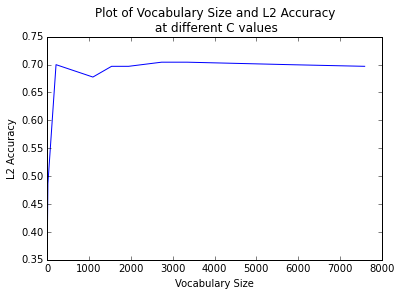

In [9]:
def plot_accuracy_vocab(Cs):
    vocab_size_list = list()
    accuracy_list = list()
    
    results = np.array(['C', 'Vocabulary Size', 'l2 Accuracy'])
    
    for c in Cs:
        np.random.seed(0)
        cv = CountVectorizer()
        cv.fit(train_data)

        train_data_matrix = cv.transform(train_data)
        dev_data_matrix = cv.transform(dev_data)


        # Number of non-zero for 'l1' penalty
        logit_clf = LogisticRegression(C=c, penalty='l1', tol=.01)
        logit_clf.fit(train_data_matrix, train_labels)
        #print "At C = {0}; Number of non-zero learned weights for 'l1' penalty = {1}".format(c, np.sum(logit_clf.coef_ != 0))

        #Sum of each weight over all the classes
        sum_of_weights_over_all_classes = np.sum(logit_clf.coef_ != 0, axis = 0)
        indices_with_nonzero_weight_sum = np.where(sum_of_weights_over_all_classes > 0)
        reduced_vocabulary = np.array(cv.get_feature_names())[indices_with_nonzero_weight_sum[0]]
        reduced_vocabulary = set(reduced_vocabulary)
        
        # Calculating accuracy for 'l2' penalty
        cv = CountVectorizer(vocabulary = reduced_vocabulary)
        train_data_matrix = cv.transform(train_data)
        dev_data_matrix = cv.transform(dev_data)
    
        logit_clf = LogisticRegression(penalty='l2', tol=.01)
        logit_clf.fit(train_data_matrix, train_labels)
        accuracy_score = logit_clf.score(dev_data_matrix, dev_labels)
        #print "Accuracy of 'l2' penalty with reduced vocabulary =", accuracy_score

        results = np.vstack((results, np.array([c, len(reduced_vocabulary), accuracy_score])))
        
    np.set_printoptions(linewidth=100, formatter={'all':lambda x: '{0}'.format(str(x).rjust(18))})
    print results
    
    plt.figure()
    plt.plot(results[1:, 1].astype(float), results[1:, 2].astype(float))
    plt.xlabel('Vocabulary Size')
    plt.ylabel('L2 Accuracy')
    plt.title('Plot of Vocabulary Size and L2 Accuracy\n at different C values')

def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    cv = CountVectorizer()
    cv.fit(train_data)

    train_data_matrix = cv.transform(train_data)
    dev_data_matrix = cv.transform(dev_data)
    
    # Number of non-zero for 'l1' penalty
    logit_clf = LogisticRegression(penalty='l1', tol=0.01)
    logit_clf.fit(train_data_matrix, train_labels)
    print "Number of non-zero learned weights for 'l1' penalty =", np.sum(logit_clf.coef_ != 0)
    l1_weights = logit_clf.coef_
 
    # Number of non-zero for 'l2' penalty
    logit_clf = LogisticRegression(penalty='l2', tol=0.01)
    logit_clf.fit(train_data_matrix, train_labels)
    print "Number of non-zero learned weights for 'l2' penalty =", np.sum(logit_clf.coef_ != 0)
    
    # Creating reduced vocabulary with non-zero weights in 'l1'
    sum_of_weights_over_all_classes = np.sum(l1_weights != 0, axis = 0)
    indices_with_nonzero_weight_sum = np.where(sum_of_weights_over_all_classes > 0)
    reduced_vocabulary = np.array(cv.get_feature_names())[indices_with_nonzero_weight_sum[0]]
    reduced_vocabulary = set(reduced_vocabulary)
    print "\nReduced vocabulary i.e. Number of features that have at least one non-zero weight =", len(reduced_vocabulary)
    
    # Re-training logistic regression with reduced vocabulary
    cv = CountVectorizer(vocabulary = reduced_vocabulary)
    train_data_matrix = cv.transform(train_data)
    dev_data_matrix = cv.transform(dev_data)

    logit_clf = LogisticRegression(penalty='l2', tol=.01)
    logit_clf.fit(train_data_matrix, train_labels)
    print "With reduced vocabulary, number of non-zero learned weights for 'l2' penalty =", np.sum(logit_clf.coef_ != 0)    
    
    ### STUDENT END ###
P6()

Cs = [0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
plot_accuracy_vocab(Cs)

** ANSWER: **  
Compared to l2 penalty, l1 penalty results in significantly less number of non-zero weights. l1 penalty produced 1878 non-zero weights while l2 penalty did not produce any weight equal to zero

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [10]:
def P7():
### STUDENT START ###
    cv = TfidfVectorizer()
    cv.fit(train_data)

    train_data_matrix = cv.transform(train_data)
    dev_data_matrix = cv.transform(dev_data)
    
    logit_clf = LogisticRegression(C=100, penalty='l2')
    logit_clf.fit(train_data_matrix, train_labels)
    logit_clf.preds = logit_clf.predict(dev_data_matrix)
    print "Accuracy of logistic Regression using TfidfVectorizer =", logit_clf.score(dev_data_matrix, dev_labels), "\n"
    logit_clf_probs_preds = logit_clf.predict_proba(dev_data_matrix)
    
    # Calculating R
    R = list()
    for i in xrange(len(dev_labels)):
        max_probability = logit_clf_probs_preds[i].max()
        pred_probability_correct_label = logit_clf_probs_preds[i][dev_labels[i]]
        R.append(max_probability / pred_probability_correct_label)
    R = np.array(R)
    R_sorted_indices = np.argsort(R)
    largest_3_R = R_sorted_indices[-3 : len(R_sorted_indices)]

    # Printing top 3 documents with largest R
    for r in largest_3_R:
        print ">> Ratio R =", R[r]
        index_max_prob = np.argsort(logit_clf_probs_preds[r])[-1]
        print "Class with maximum probability = '{0}' with probability = {1}".format(newsgroups_train.target_names[index_max_prob], logit_clf_probs_preds[r].max())
        print "Predicted Probability of correct label '{0}' = {1}".format(newsgroups_train.target_names[dev_labels[r]], logit_clf_probs_preds[r][dev_labels[r]])
        print ">> Document:"
        print dev_data[r]
        print "- - *** - -"
    
    # Printing Confusion matrix
    np.set_printoptions()
    cm = confusion_matrix(logit_clf.preds, dev_labels)
    print newsgroups_train.target_names
    print cm
        
### STUDENT END ###
P7()

Accuracy of logistic Regression using TfidfVectorizer = 0.763313609467 

>> Ratio R = 287.307385648
Class with maximum probability = 'talk.religion.misc' with probability = 0.695492735752
Predicted Probability of correct label 'alt.atheism' = 0.00242072696525
>> Document:

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

- - *** - -
>> Ratio R = 324.987934607
Class with maximum probability = 'comp.graphics' with probability = 0.979744079221
Predicted Probability of correct label 'talk.religion.misc' = 0.00301470908576
>> Document:
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
- - *** - -
>> Ratio R = 929.343915334
Class with maximum probability = 'comp.graphics' with probability = 0.993718919525
Predicted Probability of correct label 'talk.religion.misc' = 0.00106926930185
>> Document:
I am pleased to anno

** ANSWER: **  
CountVectorizer creates a matrix where each cell represents the number of times the feature has appeared in a document. Whereas, TfidfVectorizer creates a matrix where each cell represents the Tf-idf weight of each feature in the document.  
Tf-idf of a feature is calculated in the following way: Term frequency X Inverse Document Frequency.  
Term Frequency = number of times a word appeared in a document / total number of words in the document  
Inverse Document Frequency = Log_e(total number of documents / number of documents in which the word appears).  
Therefore, Tf-idf reduces the importance of common features.  
  
What kind of mistakes is the model making:  
As we can see from the Confusion Matrix, most errors are between 'talk.religion.misc' and 'alt.atheism'. From the label names it seems that words that are important to one label will be important to the other label as well. Hence the classifier is making errors.
There are also several errors between 'comp.graphics' and 'alt.atheism'. The errors between 'comp.graphics' and 'alt.atheism' are caused by the presense of 'computer like' words such as internet, download and ftp. 

Ways to address issues:  
To solve errors between 'talk.religion.misc' and 'alt.atheism', we can do the following:
- Remove stopwords
- Use the max_df parameter to to set corpus specific stop words

to solve the errors between 'comp.graphics' and 'alt.atheism', we can do the following:
- Use grammar recognition and give more weights to object of the sentences and less weight to other words.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [11]:
def P8():
    cv = TfidfVectorizer(stop_words='english', max_df = 100)
    cv.fit(train_data)

    train_data_matrix = cv.transform(train_data)
    dev_data_matrix = cv.transform(dev_data)
    
    logit_clf = LogisticRegression(C=100, penalty='l2')
    logit_clf.fit(train_data_matrix, train_labels)
    logit_clf.preds = logit_clf.predict(dev_data_matrix)
    print "Accuracy of logistic Regression using TfidfVectorizer =", logit_clf.score(dev_data_matrix, dev_labels), "\n"
    
    # Printing Confusion matrix
    np.set_printoptions()
    cm = confusion_matrix(logit_clf.preds, dev_labels)
    print newsgroups_train.target_names
    print cm
    
P8()

Accuracy of logistic Regression using TfidfVectorizer = 0.781065088757 

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
[[ 98   3   8  19]
 [  5 166   7   9]
 [ 26  15 182  17]
 [ 36   1   2  82]]


From the confusion matrix in #P7 we see that the number of errors between 'talk.religion.misc' and 'alt.atheism' was 33 + 31 = 64 with an overall accuracy of 0.763313609467.  
By applying english stopwords and corpus specific stop words (by using the max_df parameter), the errors between 'talk.religion.misc' and 'alt.atheism' has reduced to 36 + 19 = 55 and overall accuracy has increased to 0.781065088757